In [2]:
import pandas as pd
import urllib.request, json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk, gensim
from nltk import word_tokenize
from tqdm import tqdm

# 데이터 불러오기 모든 SUV 컴플레인 데이터

In [3]:
os.chdir('C:\\Users\\Moon\\Google 드라이브\\경배끄10\\인턴\\csv파일\\\complain')
data = open('final_suv_compalin_us.json').read()
data = pd.DataFrame(json.loads(data))
print(data.shape)
data.head(5)

(28236, 12)


,B_category,S_category,city,country,date,make_name,model_name,model_year,sub_title,text,title,year
0,seat_belts_air_bags,air_bags,Creek,USA,Sep 12,Volkswagen,Touareg,2012.0,"30,000 miles",While traveling on highway 24 airbag spontaneo...,Touareg,2016
1,lights,exterior_lighting,OH,USA,Apr 03,Volkswagen,Touareg,2012.0,miles,Car following me light issue. Lights on low be...,Touareg,2015
10,steering,steering,KS,USA,Apr 06,Volkswagen,Touareg,2012.0,miles,Steering wheel shakes during high way driving....,Touareg,2016
100,seat_belts_air_bags,air_bags,TN,USA,Aug 31,Chevrolet,Tahoe,2012.0,miles,2 cracks around front passenger side airbag da...,Tahoe,2016
1000,engine,engine,MI,USA,Apr 28,Jeep,Grand_Cherokee,2012.0,miles,Unexpected stall while driving. Happened twice...,Grand Cherokee,2016


In [4]:
data['model_name'].unique()

array(['Touareg', 'Tahoe', 'Grand_Cherokee', 'Sorento', 'Santa_Fe',
       'Patriot', 'X-Trail', 'Rogue', 'CR-V', 'Wrangler', 'FJ_Cruiser',
       'Compass', 'RAV4', 'Yukon', 'X5', 'Equinox', 'Escape', 'Forester',
       'Terrain', 'Tucson', 'Q7', 'CX-5', 'XC90', 'X6', 'X1', 'Tiguan',
       'Escalade', 'Sportage', 'Encore', 'Cayenne', 'Juke', 'Crosstour',
       'Trax', 'MDX', 'Durango', 'Xterra', 'Suburban', 'Sequoia',
       'Navigator', 'Expedition', 'Pathfinder', 'Murano', 'Armada', 'RDX',
       'Pilot', 'Traverse', 'Venza', 'Outlander', 'Highlander', 'MKX',
       'Flex', 'Explorer', 'Edge', 'Acadia', 'Enclave', 'XC60', 'CX-9',
       'SRX', 'X3', 'Q5', 'Cherokee', 'Escalade_ESV', 'Land_Cruiser', 'X4',
       'Macan', 'MKC', 'Q3', 'Renegade', 'Model_X', 'Envision', 'CX-3',
       '500X', 'XT5', 'F-PACE'], dtype=object)

##  텍스트를 주별로 나누기

In [5]:
len(data)

28236

In [6]:
data = data[data['country']=='USA']
print("전체 USA 컴프레인 데이터 개수 :" + str(len(data)))
print("구별되지 않는 데이터 개수 :" +str(len(data['city'].unique())))

data.index = [x for x in range(len(data))]
# 구별되지 않는 데이터 약 3700개 제외

전체 USA 컴프레인 데이터 개수 :24951
구별되지 않는 데이터 개수 :3751


In [7]:
inner = ['IL','SD','MI','MO','OH','WI','IN','MN','KS','ND','NE','IA']
west = ['CA','AZ','CO','UT','WA','NV','WY','OR','ID','MT','NM']
east = ['RI','ME','VT','DE','CT','MA','NJ','NH','MD','PA','VA','NY']
south = ['AR','LA','NC','MS','KY','AL','GA','WV','OK','FL','TN','SC','TX']

In [8]:

for index in tqdm(data.index.values):
    if (data['city'][index] in inner ):
        data.loc[index, 'City_category'] = 'Central'
    elif (data['city'][index] in west ):
        data.loc[index, 'City_category'] = 'West'
    elif (data['city'][index] in east ):
        data.loc[index, 'City_category'] = 'East'
    elif (data['city'][index] in south ):
        data.loc[index, 'City_category'] = 'South'
    else:
        data.loc[index, 'City_category'] = 0

100%|███████████████████████████████████████████████████████████████████████████| 24951/24951 [00:26<00:00, 928.64it/s]


In [9]:
real_data = data[data['City_category'] != 0]
print(real_data.shape)
real_data.head(5)

# 최종 지역 complain data 14,370개

(14370, 13)


,B_category,S_category,city,country,date,make_name,model_name,model_year,sub_title,text,title,year,City_category
1,lights,exterior_lighting,OH,USA,Apr 03,Volkswagen,Touareg,2012.0,miles,Car following me light issue. Lights on low be...,Touareg,2015,Central
2,steering,steering,KS,USA,Apr 06,Volkswagen,Touareg,2012.0,miles,Steering wheel shakes during high way driving....,Touareg,2016,Central
3,seat_belts_air_bags,air_bags,TN,USA,Aug 31,Chevrolet,Tahoe,2012.0,miles,2 cracks around front passenger side airbag da...,Tahoe,2016,South
4,engine,engine,MI,USA,Apr 28,Jeep,Grand_Cherokee,2012.0,miles,Unexpected stall while driving. Happened twice...,Grand Cherokee,2016,Central
7,wheels_hubs,wheels,IL,USA,Nov 07,Kia,Sorento,2013.0,982 miles,While drive at slow speeds of about 5 to 10 mp...,Sorento 4-cyl,2012,Central


# 주 카테고리를 지역별(4개)로 나누기

In [10]:
Highlander = real_data[real_data['model_name']=='Highlander']
Pathfinder = real_data[real_data['model_name']=='Pathfinder']
Pilot = real_data[real_data['model_name']=='Pilot']
Santa_fe = real_data[real_data['model_name']=='Santa_Fe']

hap_table = pd.concat([Highlander, Pathfinder, Pilot, Santa_fe])
print(hap_table.shape)
hap_table['model_name'].unique()

(1408, 13)


array(['Highlander', 'Pathfinder', 'Pilot', 'Santa_Fe'], dtype=object)

In [11]:
Central_text = real_data[real_data['City_category']=='Central']['text']
print("내륙 리뷰개수 : " + str(len(Central_text)))
West_text = real_data[real_data['City_category']=='West']['text']
print("서부 리뷰개수 : " + str(len(West_text)))
East_text = real_data[real_data['City_category']=='East']['text']
print("동부 리뷰개수 : " + str(len(East_text)))
South_text = real_data[real_data['City_category']=='South']['text']
print("남부 리뷰개수 : " + str(len(South_text)))

내륙 리뷰개수 : 2730
서부 리뷰개수 : 2605
동부 리뷰개수 : 4171
남부 리뷰개수 : 4864


In [12]:
import random
Central_text2 = random.sample(Central_text.tolist(),2605)
West_text2 = random.sample(West_text.tolist(),2605)
East_text2 = random.sample(East_text.tolist(),2605)
South_text2 = random.sample(South_text.tolist(),2605)

## 미국 통계청 기준 주 구역 기준

In [13]:
# test = [
# 'IL', # 일리노이 = 내륙,
# 'SD', # 사우스다코타 = 내륙,
# 'NY', # 뉴욕 = 동부,
# 'TX', # 텍사스 = 남부,
# 'MI', # 미시간 = 내륙,
# 'SC', # 사우스캐로리나 = 남부,
# 'MO', # 미소리 = 내륙,
# 'VA', # 버지니아 = 동부,
# 'PA', # 펜실베니아 = 동부,
# 'OH', # 오하이오 = 중부,
# 'CA', # 캘리보니아 = 서부,
# 'TN', # 테네시 = 남부,
# 'MD', # 메릴랜드 = 동부,
# 'NH', # 뉴햄프셔 = 동부,
# 'FL', # 플로리다 = 남부,
# 'OK', # 오클라호마 = 남부,
# 'WV', # 워싱턴 버지니아 = 남부,
# 'AZ', # 아리조나 = 서부,
# 'GA', # 조지아 = 남부,
# 'WI', # 위스콘신 = 중부,
# 'NJ', # 뉴저지 = 동부,
# 'AL', # 알라바마 = 남부,
# 'KY', # 켄터키 = 남부,
# 'CO', # 콜로라도 = 서부,
# 'IN',# 인디아나 = 중부,
# 'UT', # =서부,
# 'MA', # =동부,
# 'MN', # =중부,
# 'KS', # =중부,
# 'ND', # =중부,
# 'MS', # =남부,
# 'CT', # =동부,
# 'NC', # = 남부,
# 'LA', # =남부
# 'AR', # = 남부
# 'WA', #=서부
# 'NV', #=서부
# 'WY', #=서부
# 'OR', #오레곤 = 서부
# 'ID', #= 서부
# 'AK', #= 알래스카..
# 'NE', #= 중부
# 'MT', #= 서부
# 'DE', #=동부
# 'VT', #=동부
# 'ME', #= 동부
# 'RI', #= 동부
# 'NM', #= 서부
# 'HI' #= 하와이
# 'IA', #= 중부
# ] 

### Weather

In [15]:
os.chdir('C:\\Users\\Moon\\Google 드라이브\\경배끄10\\인턴\\csv파일')
data = open('weather.txt')

test = [ x for x in data.readlines()]
tab = []
for x in test:
    tab.append(x.split('\n')[0])
    
weather_token = tab[1:]
len(weather_token)

238

### Car categoty

In [16]:
os.chdir('C:\\Users\\Moon\\Google 드라이브\\경배끄10\\인턴\\csv파일')
data = open('car_category.txt')

test = [ x for x in data.readlines()]
tab = []
for x in test:
    tab.append(x.split('\n')[0])
    
car_category_toekn = tab[1:]
len(car_category_toekn)

47

### Car parts

In [17]:
os.chdir('C:\\Users\\Moon\\Google 드라이브\\경배끄10\\인턴\\csv파일')
data = open('car_parts.txt')

test = [ x for x in data.readlines()]
tab = []
for x in test:
    tab.append(x.split('\n')[0])
    
car_parts_toekn = tab[1:]
len(car_parts_toekn)

173

### Driving

In [18]:
os.chdir('C:\\Users\\Moon\\Google 드라이브\\경배끄10\\인턴\\csv파일')
data = open('driving.txt')

test = [ x for x in data.readlines()]
tab = []
for x in test:
    tab.append(x.split('\n')[0])
    
driving_token = tab[1:]
len(driving_token)

157

## 모든 word_list중 유의미하다고 판단된 weater, driving 리스트의 합

In [19]:
all_token = weather_token+driving_token
all_token = list(set(all_token))

## Import Package2

In [21]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import operator

## 각 지역별 Wordcloud 및 단어 출연 빈도 Scoring

In [24]:

def make_wordcloud(city, image):
    
    tokens = [ word_tokenize(word) for word in city ]

    wc_sentence =""
    for sentence in tokens:
        for word in sentence:
            if word in all_token:
                wc_sentence = wc_sentence+ " " + word 
                
    os.chdir('C:\\Users\\Moon\\Google 드라이브\\경배끄10\\인턴\\csv파일')
    car_coloring = np.array(Image.open(image+".jpg"))
    wordcloud = WordCloud(max_font_size=40,background_color="white", max_words=100000, mask=car_coloring)
    wordcloud.generate(wc_sentence)

    from wordcloud import ImageColorGenerator
    image_colors = ImageColorGenerator(car_coloring)
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear", )
    plt.axis("off")
    plt.savefig(image)
    plt.show()
    
    test = wordcloud.words_
    sorted_x = sorted(test.items(), key=operator.itemgetter(1))
    
    return sorted_x[-40:]


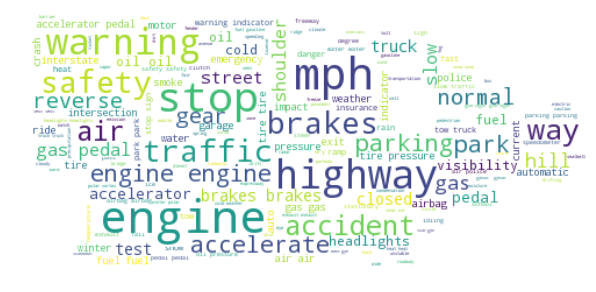

In [28]:
East_word= make_wordcloud(East_text2,'central')
# East_word= make_wordcloud(East_text2,'central')
# West_word= make_wordcloud(West_text2,'central')
# South_word= make_wordcloud(South_text2,'central')


# 각 지역별 Word 빈도 합치기

In [29]:
tab1 = pd.merge(pd.DataFrame(Central_word),pd.DataFrame(West_word),on=0, how='outer')
tab2 = pd.merge(tab1,pd.DataFrame(East_word), on=0, how='outer')
tab3 = pd.merge(tab2,pd.DataFrame(South_word), on=0, how='outer' )
tab3.columns = ['word','Central','West','East','South']
tab3

,word,Central,West,East,South
0,intersection,0.129870,0.108156,NaN,0.122407
1,air air,0.129870,NaN,NaN,0.122407
2,fuel fuel,0.129870,NaN,NaN,0.141079
3,police,0.132035,NaN,NaN,NaN
4,brakes brakes,0.132035,0.117021,0.125645,NaN
5,motor,0.136364,NaN,NaN,0.134855
6,headlights,0.136364,NaN,0.108434,NaN
7,shoulder,0.136364,0.111702,0.139415,0.141079
8,mph warning,0.136364,NaN,NaN,NaN
9,brakes stop,0.142857,NaN,NaN,NaN


## 각 지역별 단어 빈도수 Detail하게 확인하기

In [142]:
shap = pd.concat([pd.DataFrame(Central_word),pd.DataFrame(West_word),pd.DataFrame(East_word),pd.DataFrame(South_word)],axis=1)
shap.columns = ['Central','Central_score','West','West_score','East','East_score','South','South_score']
shap

,Central,Central_score,West,West_score,East,East_score,South,South_score
0,air air,0.126882,intersection,0.106643,accelerator pedal,0.114286,intersection,0.109533
1,intersection,0.129032,airbag,0.108392,visibility,0.116190,freeway,0.111562
2,police,0.131183,stop sign,0.108392,headlights,0.116190,auto,0.113590
3,shoulder,0.131183,shoulder,0.110140,garage,0.116190,test,0.115619
4,accelerator,0.133333,brakes brakes,0.110140,oil,0.118095,shoulder,0.115619
5,motor,0.133333,crash,0.113636,crash,0.118095,mph warning,0.121704
6,test,0.133333,smoke,0.117133,police,0.120000,water,0.125761
7,weather,0.133333,indicator,0.120629,oil oil,0.120000,air air,0.127789
8,brakes brakes,0.135484,stop stop,0.120629,tire tire,0.120000,garage,0.129817
9,brakes stop,0.135484,gas gas,0.125874,test,0.123810,pedal,0.137931


### 각지역 단어별 평균 구하기 (NaN value를 제외한 평균)

In [30]:
for index in range(len(tab3)):
    tab3.loc[index,'mean_value'] = tab3.loc[index].dropna().values[1:].mean()

In [31]:
tab3

,word,Central,West,East,South,mean_value
0,intersection,0.129870,0.108156,NaN,0.122407,0.120144
1,air air,0.129870,NaN,NaN,0.122407,0.126138
2,fuel fuel,0.129870,NaN,NaN,0.141079,0.135474
3,police,0.132035,NaN,NaN,NaN,0.132035
4,brakes brakes,0.132035,0.117021,0.125645,NaN,0.124900
5,motor,0.136364,NaN,NaN,0.134855,0.135609
6,headlights,0.136364,NaN,0.108434,NaN,0.122399
7,shoulder,0.136364,0.111702,0.139415,0.141079,0.132140
8,mph warning,0.136364,NaN,NaN,NaN,0.136364
9,brakes stop,0.142857,NaN,NaN,NaN,0.142857


## 통계적 유의성
* 0인 애들은 유의미하다.
* 통계적 거리가 먼 애들(p-value가 큰 애들) 유의미하다.
* 각 도시별 유의미한 단어들의 평균과 차이를 살핀다.

In [54]:
# 평균과의 차이를 통해 각 지역별 유의미한 단어들을 선정한다.
# (-) 값이 클수록 평균보다 언급 횟수가 적다
# (+) 값이 클수록 평균보다 언급 횟수가 많다
# 0.0000000 은 평균과 동일 즉, 유일하게 이 지역에서만 언급된 단어
# NaN은 언급되지 않은 단어


for x in tqdm(tab3['word'].values):
    for city in ['Central','West','East','South']:
        table = tab3.loc[tab3['word'].values == x]
        tab3.loc[tab3['word'].values == x, city] = table['mean_value'] - table[city]

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 121.41it/s]


In [70]:
Central_static = tab3[['word','Central']].sort_values('Central')
Central_static.index = [ x for x in range(len(Central_static))]

East_static = tab3[['word','East']].sort_values('East')
East_static.index = [ x for x in range(len(East_static))]

West_static = tab3[['word','West']].sort_values('West')
West_static.index = [ x for x in range(len(West_static))]

South_static = tab3[['word','South']].sort_values('South')
South_static.index = [ x for x in range(len(South_static))]


shap2 = pd.concat([Central_static, West_static, East_static, South_static], axis=1)
shap2.columns = ['Central','Central_score','West','West_score','East','East_score','South','South_score']
shap2

,Central,Central_score,West,West_score,East,East_score,South,South_score
0,pedal,-0.113943,freeway,-0.142624,highway,-0.141672,safety,-0.124362
1,stop,-0.105823,park,-0.069976,brakes,-0.057373,mph,-0.096856
2,mph,-0.096856,fuel,-0.038732,reverse,-0.030786,accident,-0.081620
3,gas,-0.093141,gas pedal,-0.037969,stop,-0.023494,stop,-0.071344
4,safety,-0.069405,engine engine,-0.037435,accident,-0.010256,air,-0.066678
5,way,-0.068394,garage,-0.026301,engine,-0.009606,traffic,-0.049290
6,warning,-0.059883,oil,-0.018973,mph,-0.009077,way,-0.048096
7,traffic,-0.052981,street,-0.018599,shoulder,-0.007275,airbag,-0.045658
8,engine engine,-0.047014,gear,-0.017814,parking,-0.003475,highway,-0.042816
9,street,-0.046484,accelerate,-0.014225,brakes brakes,-0.000745,fuel,-0.036113


## 시각화용 Wordcloud

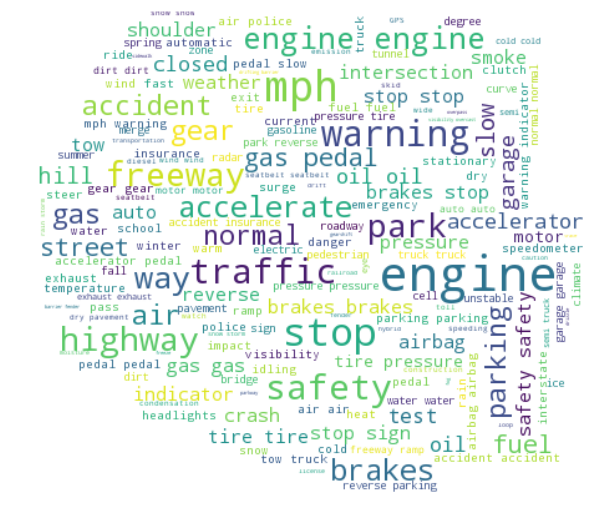

In [30]:
West_word = make_wordcloud(West_text2,'west')
# 산악지대
# engine을 중요시

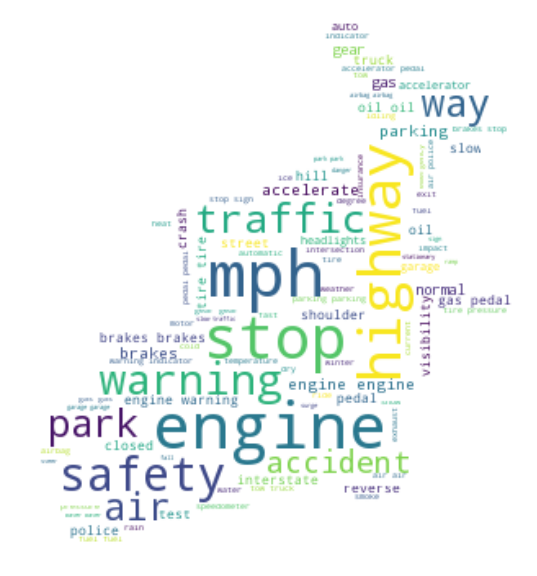

In [31]:
East_word = make_wordcloud(East_text2,'east')

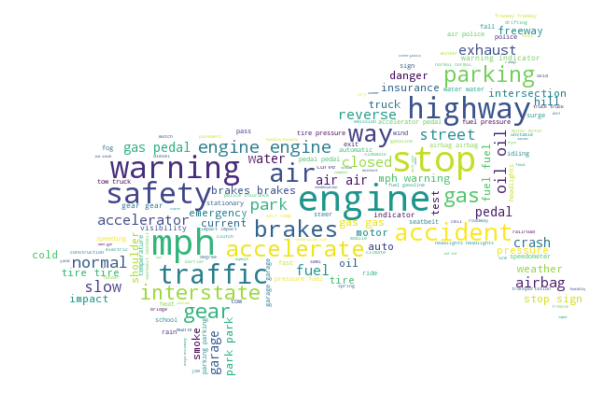

In [32]:
South_word = make_wordcloud(South_text2,'south')
# park 랑 거리가 멈
# air 큼
# water

In [115]:
test=[]
for index in range(40):
    test.append(Central_word[index][0])
    test.append(East_word[index][0])
    test.append(West_word[index][0])
    test.append(South_word[index][0])
    
all_text_list = list(set(test))
    


In [133]:
dummy = pd.DataFrame(np.arange(1).reshape(1,1))

In [134]:
for word_list in [Central_word, West_word, East_word, South_word]:
    check_list = [ word_list[x][0] for x in range(40) ]
    X=[]
    for x in all_text_list:
        if( x in check_list):
            X.append(1)
        else:
            X.append(0)

    call = pd.DataFrame(X, index=all_text_list)
    final = pd.concat([dummy,call], axis=1)
    dummy = final

final.columns = [0,'Central','West','East','South']
final = final.drop(0)
final = final.drop([0],axis=1)
final

C:\Users\kb910\Anaconda3\lib\site-packages\pandas\indexes\range.py:432: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  return self._int64index.union(other)


,Central,West,East,South
indicator,0.0,1.0,0.0,0.0
shoulder,1.0,1.0,1.0,1.0
oil,1.0,1.0,1.0,0.0
intersection,1.0,1.0,0.0,1.0
freeway,0.0,1.0,0.0,1.0
air,1.0,1.0,1.0,1.0
test,1.0,1.0,1.0,1.0
hill,0.0,1.0,1.0,0.0
brakes stop,1.0,0.0,0.0,0.0
water,0.0,0.0,0.0,1.0


## 지역별 차종 count(참고사항)

In [104]:
def Make_TDM(data):
    
    tdm_table = data
    voca = ['truck','suv','sedan','van','minivan','hatchback','compact','luxury']
    test = [ str(x) for x in tdm_table ] 

    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(vocabulary=voca)
    context = test
    X = vectorizer.fit_transform(context)
    TDM_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

    for column in TDM_matrix.columns:
        TDM_matrix.loc[TDM_matrix[column] != 0, column] = 1

    TDM_matrix.loc[('sum_count')] = [ TDM_matrix[x].sum() for x in TDM_matrix.columns ]
    
    return TDM_matrix

In [105]:
print((Make_TDM(Central_text2).loc['sum_count']/len(Central_text2))*100)
print((Make_TDM(West_text2).loc['sum_count']/len(West_text2))*100)
print((Make_TDM(East_text2).loc['sum_count']/len(East_text2))*100)
print((Make_TDM(South_text2).loc['sum_count']/len(South_text2))*100)


truck        3.301344
suv          1.420345
sedan        0.038388
van          0.115163
minivan      0.038388
hatchback    0.230326
compact      0.038388
luxury       0.038388
Name: sum_count, dtype: float64
truck        3.109405
suv          1.612284
sedan        0.000000
van          0.191939
minivan      0.038388
hatchback    0.268714
compact      0.000000
luxury       0.115163
Name: sum_count, dtype: float64
truck        3.416507
suv          1.842610
sedan        0.038388
van          0.115163
minivan      0.115163
hatchback    0.000000
compact      0.000000
luxury       0.115163
Name: sum_count, dtype: float64
truck        2.495202
suv          1.420345
sedan        0.000000
van          0.115163
minivan      0.000000
hatchback    0.038388
compact      0.000000
luxury       0.076775
Name: sum_count, dtype: float64
